### Target data distribution p1(x1), original code used a checkerboard sampling method, replace with actual target data 

Data preparation (cell 2): Now keeps only tail data and normalizes HiggsM values for conditioning.

Model (cell 7): ConditionalMLP now accepts three inputs:

x: frequency data
t: time step
cond: normalized HiggsM value
The HiggsM conditioning information is projected and added to the network, allowing the model to learn how the velocity field varies with HiggsM.

Training (cell 9): Now passes the corresponding HiggsM value for each frequency sample during training.

Sampling (cell 12): Samples across the entire HiggsM range including the pole region. The model uses learned patterns from tail data to extrapolate predictions into the pole region where it has no direct training data.

The key insight: the model learns "how frequencies behave at this HiggsM value" from the tails, then applies that learned pattern to generate predictions in the pole region.

In [1]:
import tqdm
import math
import torch
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Set device - use CUDA if available, otherwise CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

raw_df = pd.read_hdf('data_files/new_Input_NonResonant_yy_25th_January2026.h5', key='VBF_Polarisation_Tree')

# Define bounds and number of bins
lower_bound = 115000
upper_bound = 135000
num_bins = 1100

# Creating frequency distribution for HiggsM
freq = pd.cut(raw_df['HiggsM'], bins=num_bins)
freq_counts = freq.value_counts().sort_index()
higgsM_values = [interval.mid for interval in freq_counts.index]
frequencies = freq_counts.values.tolist()

# Create DataFrame for ML Model
# Applying the bounds to HiggsM values
model_df = pd.DataFrame({'HiggsM': higgsM_values, 'Frequency': frequencies})
mask1 = model_df['HiggsM'] > upper_bound
mask2 = model_df['HiggsM'] < lower_bound
model_df_tails = model_df[mask1 | mask2]

# Applying the same bounds to the raw data for the other features
grouped_df = raw_df.groupby(pd.cut(raw_df['HiggsM'], bins=num_bins), observed=True).mean(numeric_only=True)
grouped_df.index.name = 'HiggsM_interval'
grouped_df = grouped_df.reset_index()
grouped_df['HiggsM_interval'] = grouped_df['HiggsM_interval'].apply(lambda x: x.mid).astype(float)
mask3 = grouped_df['HiggsM_interval'] > upper_bound
mask4 = grouped_df['HiggsM_interval'] < lower_bound
others_df_tails = grouped_df[mask3 | mask4]

# Combine tail data for other features and HiggsM frequency into a single DataFrame for training
model_df_tails.index.name = others_df_tails.index.name
combined_tails_df = pd.concat([model_df_tails, others_df_tails.drop(columns=['HiggsM', 'HiggsM_interval'])], axis=1)

# Save the combined tails DataFrame to a CSV file for inspection
# Filter out unnecessary columns and save the relevant features along with HiggsM and Frequency
combined_tails_df.to_csv('data_dump/combined_tails_data.csv')
features = ['DNN_score', 'Frequency', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1']
features_array = combined_tails_df[features].to_numpy()
num_features = features_array.shape[1]
# print(features_array.shape)
# print(features_array[:5, :])

# Array of HiggsM values for training
HiggsM_array = combined_tails_df['HiggsM'].to_numpy()



Using device: cpu


In [2]:
from sklearn.preprocessing import MinMaxScaler


# Normalise function
# Un-nomralise later using sampled_points_original = scaler.inverse_transform(sampled_points_normalized)
scaler_features = MinMaxScaler()
scaler_HiggsM = MinMaxScaler()

# Normalise features and HiggsM separately
features_normalised = scaler_features.fit_transform(features_array)
HiggsM_normalised = scaler_HiggsM.fit_transform(HiggsM_array.reshape(-1, 1))

### Random noise data points to start with, this is the initial distribution p0(x0), original code used random noise, replace with the Higgs tail data.


## Model

### This part shouldn't change for now, additional features will be added later on for more advanced models

In [3]:
class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class ConditionalMLP(nn.Module):
    def __init__(self, channels_data=num_features, layers=5, channels=512, channels_t=512, channels_cond=128, cond_dim=1):
        super().__init__()
        self.channels_t = channels_t
        self.channels_cond = channels_cond
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)

        # Condition (HiggsM) projection
        self.cond_projection = nn.Linear(cond_dim, channels_cond)
        self.cond_to_channels = nn.Linear(channels_cond, channels)

        self.blocks = nn.Sequential(*[
            Block(channels) for _ in range(layers)
        ])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10000):
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb = math.log(max_positions) / (half_dim - 1)
        emb = torch.arange(half_dim, device=t.device).float().mul(-emb).exp()
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.channels_t % 2 == 1:  # zero pad
            emb = nn.functional.pad(emb, (0, 1), mode='constant')
        return emb

    def forward(self, x, t, cond):
        # x: [batch, channels_data] (features)
        # t: [batch] (time)
        # cond: [batch, cond_dim] (HiggsM normalized)
        x = self.in_projection(x)
        t = self.gen_t_embedding(t)
        t = self.t_projection(t)
        cond = self.cond_projection(cond)  # [batch, channels_cond]
        cond = self.cond_to_channels(cond)  # [batch, channels]
        # Combine: data + time + condition
        x = x + t + cond
        x = self.blocks(x)
        x = self.out_projection(x)
        return x

In [4]:
model = ConditionalMLP(
    channels_data=num_features,
    layers=5,
    channels=512,
    channels_cond=128,
    cond_dim=1,
    )
model = model.to(device)  # Move model to GPU/CPU
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

channels_data is the dimensionality of the data the model is trying to predict.

In the original checkerboard example, channels_data=2 because each data point had 2 features: (x, y) coordinates.

In your Higgs background model, channels_data=1 because:

Input data: Only frequency (1-dimensional)
Output: Predicted frequency (1-dimensional)
HiggsM: Now a separate conditioning input, not part of the main data
So the flow matching pipeline is:

x: 1D frequency values
t: time parameter
cond: HiggsM value (controls what the model predicts)
The model learns to transform 1D noise → 1D frequency predictions, conditioned on where you are in the HiggsM spectrum.

If you later wanted to add more features (e.g., predict frequency and some other variable simultaneously), you'd increase channels_data accordingly.

## Training

### Again this shouldn't change much for now aside from the distributions being used

In [5]:
# Separate HiggsM and Frequency data (both normalized)
features_data = torch.Tensor(features_normalised).to(device)  # [N, 8] - normalized to [0, 1]
higgsM_data = torch.Tensor(HiggsM_normalised).to(device)  # [N, 1] - normalized to [0, 1]

training_steps = 17491
batch_size = 64
pbar = tqdm.tqdm(range(training_steps))
losses = []
for i in pbar:
    # Sample random indices
    idx = torch.randint(features_data.size(0), (batch_size,))
    # Get frequency data (x1 is the target tail frequency)
    x1 = features_data[idx]  # [batch, 8]
    # Get corresponding HiggsM conditioning values
    cond = higgsM_data[idx]  # [batch, 1]

    x0 = torch.randn_like(x1)
    target = x1 - x0
    t = torch.rand(x1.size(0)).to(device)
    xt = (1 - t[:, None]) * x0 + t[:, None] * x1

    # Model prediction (now conditioned on HiggsM)
    pred = model(xt, t, cond)

    loss = ((target - pred)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())


100%|██████████| 17491/17491 [04:14<00:00, 68.75it/s, loss=0.146] 


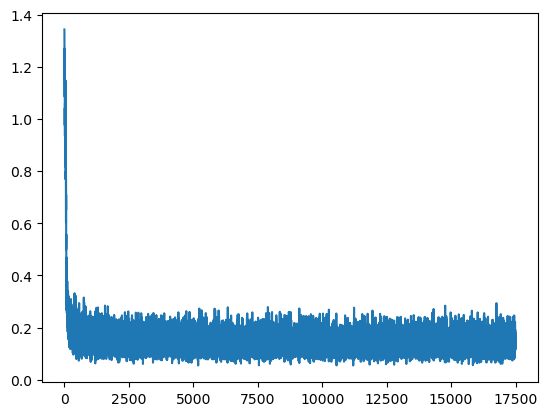

In [6]:
plt.plot(losses)

## Sampling

### Same thing as Model and Training section

In [7]:
torch.manual_seed(42)
model.eval().requires_grad_(False)

# Gives the shape (number of points) of the pole region data
full_combined_df = pd.concat([model_df, grouped_df.drop(columns=['HiggsM_interval'])], axis=1)
combined_df_pole = full_combined_df[~(mask1 | mask2)]
true_points = combined_df_pole.to_numpy()

# Sample across the full HiggsM range (tails + pole region)
# Ensures that the number of samples in the pole region matches the number of true points
num_samples_per_region = true_points.shape[0]
steps = 1000

# Build HiggsM samples (already normalized)
HiggsM_min = 0.0
HiggsM_max = 1.0
# Normalise the lower and upper bounds for the pole region using the same scaler as HiggsM
lower_bound_norm = scaler_HiggsM.transform([[lower_bound]])[0, 0]
upper_bound_norm = scaler_HiggsM.transform([[upper_bound]])[0, 0]
# Generate samples for tails and pole region
HiggsM_tail_low = np.linspace(HiggsM_min, lower_bound_norm, num_samples_per_region)
HiggsM_pole = np.linspace(lower_bound_norm, upper_bound_norm, num_samples_per_region)
HiggsM_tail_high = np.linspace(upper_bound_norm, HiggsM_max, num_samples_per_region)
HiggsM_sample = np.concatenate([HiggsM_tail_low, HiggsM_pole, HiggsM_tail_high])
HiggsM_sample_norm = HiggsM_sample

# Initialize noise on device (same feature dimension as training data)
xt = torch.randn(len(HiggsM_sample), features_array.shape[1], device=device)
cond = torch.Tensor(HiggsM_sample_norm[:, None]).to(device)

# Sampling process
plot_every = 100
for step, t in enumerate(torch.linspace(0, 1, steps), start=1):
    with torch.no_grad():
        pred = model(xt, t.expand(xt.size(0)).to(device), cond)
    xt = xt + (1 / steps) * pred
    if step % plot_every == 0:
        print(f"{int(step/plot_every)}00 steps done")
        xt_denorm = xt.detach().cpu().numpy()

model.train().requires_grad_(True)
print("Done")

100 steps done
200 steps done
300 steps done
400 steps done
500 steps done
600 steps done
700 steps done
800 steps done
900 steps done
1000 steps done
Done


In [9]:
# Denormalising the values produced by the model
HiggsM_denorm = scaler_HiggsM.inverse_transform(HiggsM_sample_norm.reshape(-1, 1)).flatten()
features_denorm = scaler_features.inverse_transform(xt.detach().cpu().numpy())

pred_points = pd.DataFrame({'HiggsM': HiggsM_denorm,
                            'DNN_score': features_denorm[:, 0],
                            'Frequency': features_denorm[:, 1],
                            'DPhi_jj': features_denorm[:, 2],
                            'Eta_jj': features_denorm[:, 3], 
                            'M_jj': features_denorm[:, 4],
                            'Njets': features_denorm[:, 5],
                            'OO1': features_denorm[:, 6],
                            })

# Constructing the pole region data for both the predicted and true data
model_df_pole = model_df[~(mask1 | mask2)]
others_df_pole = grouped_df[~(mask3 | mask4)]
model_df_pole.index.name = others_df_pole.index.name
true_points = pd.concat([model_df_pole, others_df_pole.drop(columns=['HiggsM', 'HiggsM_interval'])], axis=1)
variables = ['HiggsM', 'DNN_score', 'Frequency', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1']
true_points = true_points[variables]
lower_bound = 115000
upper_bound = 135000
pred_points_pole = pred_points[(pred_points['HiggsM'] >= lower_bound) & (pred_points['HiggsM'] <= upper_bound)]

# Saving data to csv for comparison
csv1 = pd.DataFrame(pred_points_pole, columns=['HiggsM', 'DNN_score', 'Frequency', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1'])
csv2 = pd.DataFrame(true_points, columns=['HiggsM', 'DNN_score', 'Frequency', 'DPhi_jj', 'Eta_jj', 'M_jj', 'Njets', 'OO1'])
csv1.to_csv('data_dump/multi_predicted_pole_region.csv', index=False)
csv2.to_csv('data_dump/multi_true_pole_region.csv', index=False)



## KL Divergence calculation to assess quality of the model


In [10]:
# Ensuring that both arrays have the same shape for KL Divergence calculation by trimming both ends
counter = 0
if pred_points_pole.shape > true_points.shape:
    while pred_points_pole.shape != true_points.shape:
        if counter % 2 == 0: 
            pred_points_pole = np.delete(pred_points_pole, -1, axis=0)
            counter += 1
        else:
            pred_points_pole = np.delete(pred_points_pole, 0, axis=0)
        counter += 1

elif pred_points_pole.shape < true_points.shape:
    while pred_points_pole.shape != true_points.shape:
        if counter % 2 == 0: 
            true_points = np.delete(true_points, -1, axis=0)
            counter += 1
        else:
            true_points = np.delete(true_points, 0, axis=0)
            counter += 1
        

# Convert true_points to a numpy array, pred_points_pole is already a numpy array
true_points_array = true_points.to_numpy()
print(true_points_array.shape, pred_points_pole.shape)

# Implement KL Divergence calculation
for i in range(len(features)):
    true_sum = np.sum(true_points_array[:, i])
    p = np.array(true_points_array[:, i]) / true_sum
    pred_sum = np.sum(pred_points_pole[:, i])
    q = np.array(pred_points_pole[:, i]) / pred_sum

    epsilon = 1e-10
    p_smooth = p + epsilon
    q_smooth = q + epsilon

    kl_divergence = np.sum(p_smooth * np.log(p_smooth / q_smooth))
    
    
    if np.isinf(kl_divergence) or np.isnan(kl_divergence):
        error_df = pd.DataFrame(p_smooth/q_smooth)
        error_df.to_csv('data_dump/check.csv', index=False)


    if i==3:
        error_df = pd.DataFrame(p_smooth/q_smooth)
        error_df.to_csv('data_dump/check1.csv', index=False)


    print(f"KL Divergence between true and predicted distributions in the pole region: {kl_divergence} for feature {features[i]}")






(400, 8) (400, 8)
KL Divergence between true and predicted distributions in the pole region: 9.022945566141522e-09 for feature DNN_score
KL Divergence between true and predicted distributions in the pole region: 0.00011006198634116359 for feature Frequency
KL Divergence between true and predicted distributions in the pole region: 0.001026079114787892 for feature DPhi_jj
KL Divergence between true and predicted distributions in the pole region: 1.6471510407342e-05 for feature Eta_jj
KL Divergence between true and predicted distributions in the pole region: 1.2014802021659376e-05 for feature M_jj
KL Divergence between true and predicted distributions in the pole region: 8.364150537747126e-05 for feature Njets
KL Divergence between true and predicted distributions in the pole region: 1.9099076413029158e-05 for feature OO1
